# ADD UMAP coordinates for displaying the different vocalizations in SoundSep. Requires H5 files previously saved

In [1]:
# if umap coordinates didn't get added in during the initial clustering do it here
from scipy.signal import spectrogram, butter, sosfilt, sosfiltfilt, correlate
from scipy.io.wavfile import read, write
import IPython.display as ipd
# import sys
from collections import Counter
import os
import pandas as pd
# import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import pickle
import csv
from soundsig.sound import BioSound 
from soundsig.sound import WavFile

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.decomposition import PCA



# from ipywidgets import interact, fixed
# from ipywidgets import widgets
import matplotlib.pyplot as plt

In [2]:
fs = 48000 # CAREFUL - this is hard coded and should be read from the file
# import our saved data
base_folder = '/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023'
segments_file = os.path.join(base_folder, '_appdata/save/', 'segments.csv')
segs_df = pd.read_csv(segments_file)
print(segs_df.describe())
segs_df.head()

vocSelTable = pd.read_hdf(os.path.join(base_folder, 'vocSelTableAmp.h5')) # haven't tried this yet
print('\n')
print(f'length of vocSelTableFull: {len(vocSelTable)}')
print(vocSelTable.head())

        Unnamed: 0  SourceChannel    StartIndex     StopIndex
count  4344.000000    4344.000000  4.344000e+03  4.344000e+03
mean   2171.500000       1.402855  1.297683e+08  1.297744e+08
std    1254.149114       1.050970  8.280671e+07  8.280669e+07
min       0.000000       0.000000  7.050340e+05  7.095020e+05
25%    1085.750000       0.000000  5.085730e+07  5.086201e+07
50%    2171.500000       2.000000  1.273715e+08  1.273772e+08
75%    3257.250000       2.000000  1.937890e+08  1.937933e+08
max    4343.000000       3.000000  2.980894e+08  2.980926e+08


length of vocSelTableFull: 4344
          Bird  project.start_index calltype         fund   devfund    cvfund  \
0  WhiWhi6607F                 1134    ["0"]   602.035277  0.020312  0.123225   
1  BluGre1214F                  951    ["6"]   532.179639  0.659361  0.171370   
2  BluGre1214F                 3202    ["5"]  1004.070215 -1.918334  1.029701   
3  WhiWhi6607F                 2406    ["6"]   606.338279  0.138851  0.031357   
4  

In [3]:
# Read the annotated syllabes csv  (segments.csv) file to get information on solo vs overlapp as well as other things

syll_file_name = os.path.join(base_folder,'_appdata','save','segments.csv')
print(syll_file_name)

syllTable = pd.read_csv(syll_file_name, sep=',',header=0) 


vocSelTable = pd.merge(left=vocSelTable, right=syllTable, left_on='project.start_index', right_index=True) # it's possible that I'm losing a couple rows here
birds = np.unique(vocSelTable['Bird'])
vocSelTable.head()

/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/_appdata/save/segments.csv


,Bird,project.start_index,calltype,fund,devfund,cvfund,maxfund,minfund,F1,F2,...,stdT,skewT,kurtT,entT,Unnamed: 0,SourceName,SourceChannel,StartIndex,StopIndex,Tags
0,WhiWhi6607F,1134,"[""0""]",602.035277,0.020312,0.123225,676.056338,480.000000,1927.151857,5606.097997,...,0.077088,-0.031718,2.037413,0.966456,1134,WhiWhi6607F,1,57079776,57094045,[]
1,BluGre1214F,951,"[""6""]",532.179639,0.659361,0.171370,592.592593,298.136646,1223.147592,4405.922739,...,0.021608,-0.048306,1.941768,0.994068,951,BluGre1214F,2,44063751,44067712,[]
2,BluGre1214F,3202,"[""5""]",1004.070215,-1.918334,1.029701,3428.571429,539.325843,3282.440047,5674.842286,...,0.011271,-0.066505,1.931446,0.993494,3202,BluGre1214F,2,190241518,190243570,[]
3,WhiWhi6607F,2406,"[""6""]",606.338279,0.138851,0.031357,631.578947,564.705882,1153.195682,2492.185919,...,0.026952,-0.015422,1.876354,0.998047,2406,WhiWhi6607F,1,139155682,139160389,[]
4,BroGre1354M,311,"[""5""]",538.920136,0.645045,0.054985,564.705882,484.848485,2085.536237,3634.836575,...,0.016000,-0.036766,1.929756,0.993356,311,BroGre1354M,0,19825492,19828354,[]


['[]' '["wingflap"]' '["distance call?"]']
['' 'wingflap' 'distance call?']


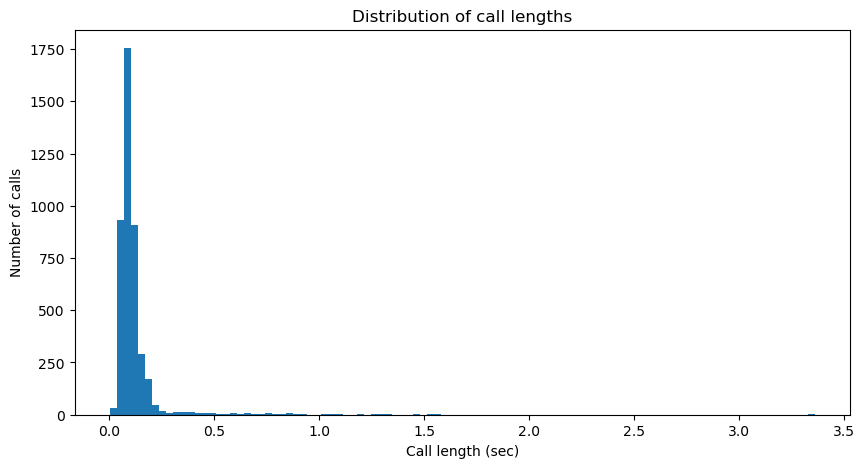

In [4]:
# pick the columns we want to use for clustering
# calculate the length of each call
vocSelTable['callLength'] = (vocSelTable['StopIndex'] - vocSelTable['StartIndex']) / fs
 
# plot the distribution of call lengths
plt.figure(figsize=(10, 5))
plt.hist(vocSelTable['callLength'], bins=100)
plt.xlabel('Call length (sec)')
plt.ylabel('Number of calls')
plt.title('Distribution of call lengths')

# The tags have extra characters that I don't want
print(vocSelTable['Tags'].unique())
# it appears they have a '[""]' surrounding them
vocSelTable['Tags'] = vocSelTable['Tags'].str.strip('[""]')
print(vocSelTable['Tags'].unique())
# change the tags column of the df to the stripped version
vocSelTable['Tags'] = vocSelTable['Tags'].str.strip('[""]')

In [5]:
# Generate the data array of biosound features
# X is the data array of features.
startFeat = 3
endFeat = 10
startFeat2 = 11
endFeat2 = 27
# note I added callLength to the features, which is the last one
salInd = 7

XFeatureNames = np.array(np.hstack((vocSelTable.columns[startFeat:endFeat],vocSelTable.columns[startFeat2:endFeat2],vocSelTable.columns[-1:])))
print('Features chosen:', XFeatureNames)
nfeatures = len(XFeatureNames)
X = np.hstack([vocSelTable.iloc[:,startFeat:endFeat],vocSelTable.iloc[:,startFeat2:endFeat2],vocSelTable.iloc[:,-1:]])
print(X.shape)

Features chosen: ['fund' 'devfund' 'cvfund' 'maxfund' 'minfund' 'F1' 'F2' 'sal' 'rms'
 'maxAmp' 'meanS' 'stdS' 'skewS' 'kurtS' 'entS' 'q1' 'q2' 'q3' 'meanT'
 'stdT' 'skewT' 'kurtT' 'entT' 'callLength']
(4344, 24)


In [6]:
X

array([[ 6.02035277e+02,  2.03123503e-02,  1.23224848e-01, ...,
         2.03741336e+00,  9.66455651e-01,  2.97270833e-01],
       [ 5.32179639e+02,  6.59360786e-01,  1.71370121e-01, ...,
         1.94176847e+00,  9.94067531e-01,  8.25208333e-02],
       [ 1.00407021e+03, -1.91833379e+00,  1.02970056e+00, ...,
         1.93144582e+00,  9.93493751e-01,  4.27500000e-02],
       ...,
       [ 5.49876920e+02, -1.26702566e-01,  2.23593750e-01, ...,
         1.91324171e+00,  9.95226218e-01,  1.10229167e-01],
       [ 5.53899881e+02, -2.09533787e+00,  3.23585097e-02, ...,
         1.83135311e+00,  9.90856302e-01,  6.18958333e-02],
       [ 5.33541224e+02, -2.60503162e-01,  2.64775905e-02, ...,
         1.93280867e+00,  9.93549556e-01,  9.98750000e-02]])

In [7]:
X.shape

(4344, 24)

In [8]:
# find the nans and exclude them
nanInd = np.where(np.isnan(X))
# determine which rows have no nans and make a cleanindex based on that
# iterate through every row and if there are no nans in that row, add it to the clean index
cleanInd = list()
i=0
for row in X:
    # print(row.shape)
    if np.isnan(row).any() == False:
        cleanInd.append(i)
    i+=1

# cleanInd = np.where(~np.isnan(X))
print('There are ', len(nanInd[0]), ' NaNs in the data')
cleanX = np.delete(X, nanInd[0], axis=0)
print('Cleaned data shape:', cleanX.shape)
# print('length cleaned index:', len(cleanInd))


There are  4  NaNs in the data
Cleaned data shape: (4340, 24)


In [9]:
# XBirds= []
# indGoodBirds = []
# infoBirds = []
# nsyllBirds = []
    

# # Find the rows that have the full data set
# indGood = np.where((np.sum(np.invert(np.isnan(X)), axis=1) == nfeatures))[0]
# indBad = np.where((np.sum(np.invert(np.isnan(X)), axis=1) != nfeatures))[0]
# # print(f'badfiles = {indBad}')
# indGoodBirds.append(indGood)

# # print('nsyll=', len(indGood), '/', X.shape[0])
# nsyllBirds.append(len(indGood))
# # How many rows are we losing?
# print('Number of rows lost:', X.shape[0] - len(indGood))
# print('Out of how many rows?', X.shape[0])

# # calculate which features are contributing to the missing data
# # def print_missing_features(X, XFeatureNames, indBad):
# #     missing_features = list()
# #     for feature in XFeatureNames:
# #         num_missing=0
# #         for indBad in indBad: 
# #             if np.isnan(X[indBad,np.where(XFeatureNames == feature)[0][0]]):
# #                 num_missing += 1
# #         if num_missing > 0: print(f'num missing {feature} = {num_missing}')

# print_missing_features(X, XFeatureNames, indBad)

# cleanX = X[indGood,:]
# cleanTags = vocSelTableFull.iloc[indGood,0:3]
# print('dimensions of cleanX:', cleanX.shape)
# # print cleantages unique
# print('unique call types:', np.unique(cleanTags['calltype']))

Shape of Z_PCA_All: (4340, 10)


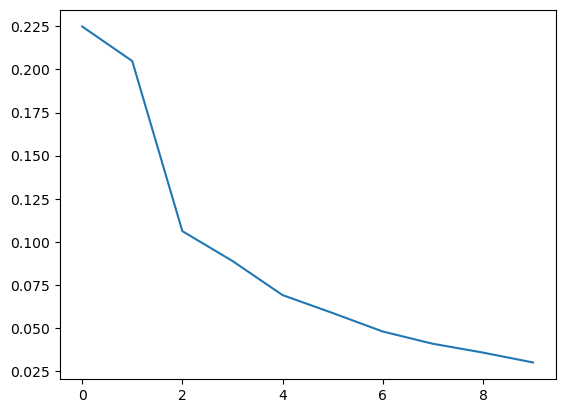

In [10]:
meanBalancedAll = np.mean(cleanX, axis = 0)
sdBalancedAll = np.std(cleanX, axis = 0, ddof=1)
ZBalancedAll = (cleanX - meanBalancedAll)/sdBalancedAll

# PCA the data
pcaBalanced = PCA(n_components=10, svd_solver='full')
Z_PCA_Balanced_All = pcaBalanced.fit_transform(ZBalancedAll)

print("Shape of Z_PCA_All:", Z_PCA_Balanced_All.shape)

# Plot the explainable variance
plt.plot(pcaBalanced.explained_variance_ratio_)

(4340, 10)


Text(0.5, 1.0, 'PCA of the data, balanced and zscored, 10 components, 2 dimensions')

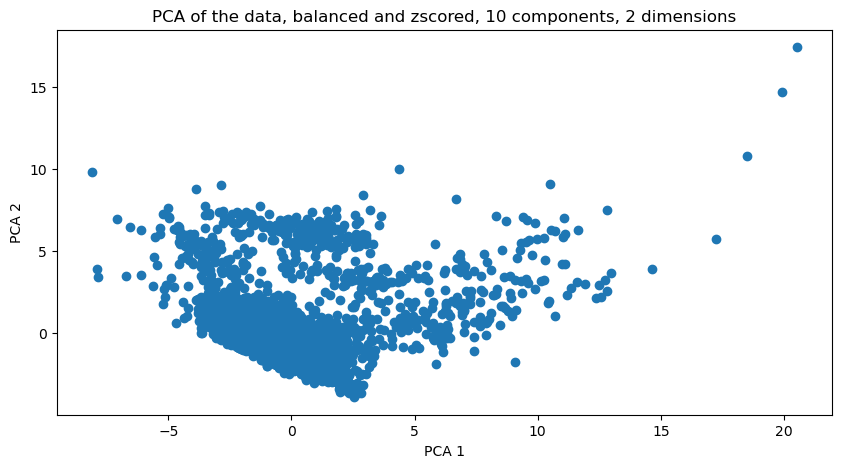

In [11]:
print(Z_PCA_Balanced_All.shape)
# Plot the first two components
plt.figure(figsize=(10, 5))
plt.scatter(Z_PCA_Balanced_All[:,0], Z_PCA_Balanced_All[:,1], cmap = 'tab20')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of the data, balanced and zscored, 10 components, 2 dimensions')

In [12]:
# Take the z-scored PCA data and run UMAP on it

MAXSYLL = 40
umapFit = umap.UMAP(
        n_neighbors=int(len(Z_PCA_Balanced_All)/MAXSYLL),
        min_dist=0.1,
        n_components=3,
        random_state=42).fit(Z_PCA_Balanced_All)

umapAll = umapFit.transform(Z_PCA_Balanced_All)



/opt/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


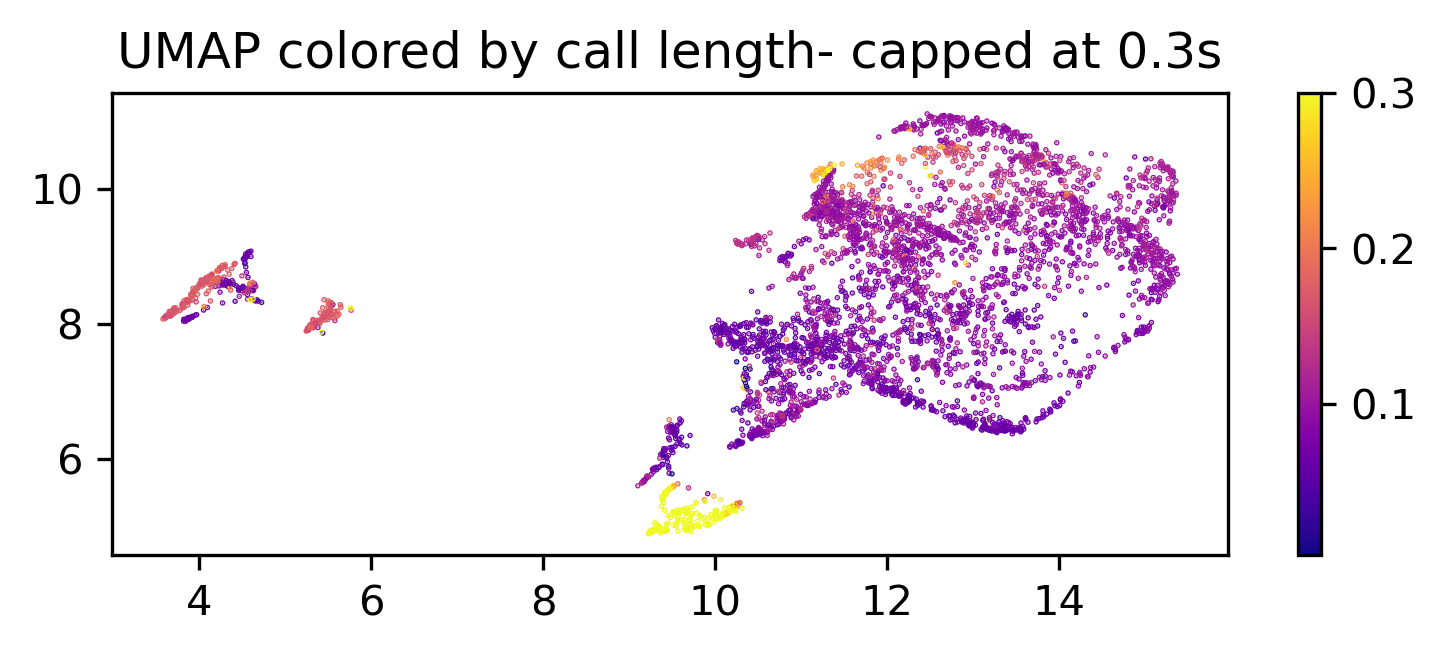

In [13]:
c=cleanX[:,-1] # call length
c[c>.3]=.3
plt.figure(figsize=(6,2), dpi=300)
plt.scatter(umapAll[:, 0], umapAll[:, 1], s=0.1, c=c, cmap='plasma')
plt.title('UMAP colored by call length- capped at 0.3s')
plt.colorbar()



In [14]:
c_index[1]

NameError: name 'c_index' is not defined

In [ ]:
# make a new array called 'color_labels' and set it to the integer values of the calltype column in vocSelTable
# first clean the calltype column
color_labels = vocSelTable['calltype'].str.strip('[""]').values
color_labels = [20 if x == '' else x for x in color_labels]
color_labels = [int(x) for x in color_labels]

In [ ]:

# make a new array called 'color_labels' and set it to the integer values of the calltype column in vocSelTable
# first clean the calltype column
color_labels = vocSelTable['calltype'].str.strip('[""]').values
color_labels = [20 if x == '' else x for x in color_labels]
color_labels = [int(x) for x in color_labels]

c_index = np.array(cleanInd)
c_index = c_index.astype(int)
clean_color_labels = color_labels[c_index]

#plot the umap with the color labels
plt.figure(figsize=(6,2), dpi=300)
plt.scatter(umapAll[:, 0], umapAll[:, 1], s=0.1, c=clean_color_labels, cmap='tab20')
plt.title('UMAP colored by call type')
plt.colorbar()


TypeError: only integer scalar arrays can be converted to a scalar index

ValueError: 'c' argument has 104252 elements, which is inconsistent with 'x' and 'y' with size 4340.

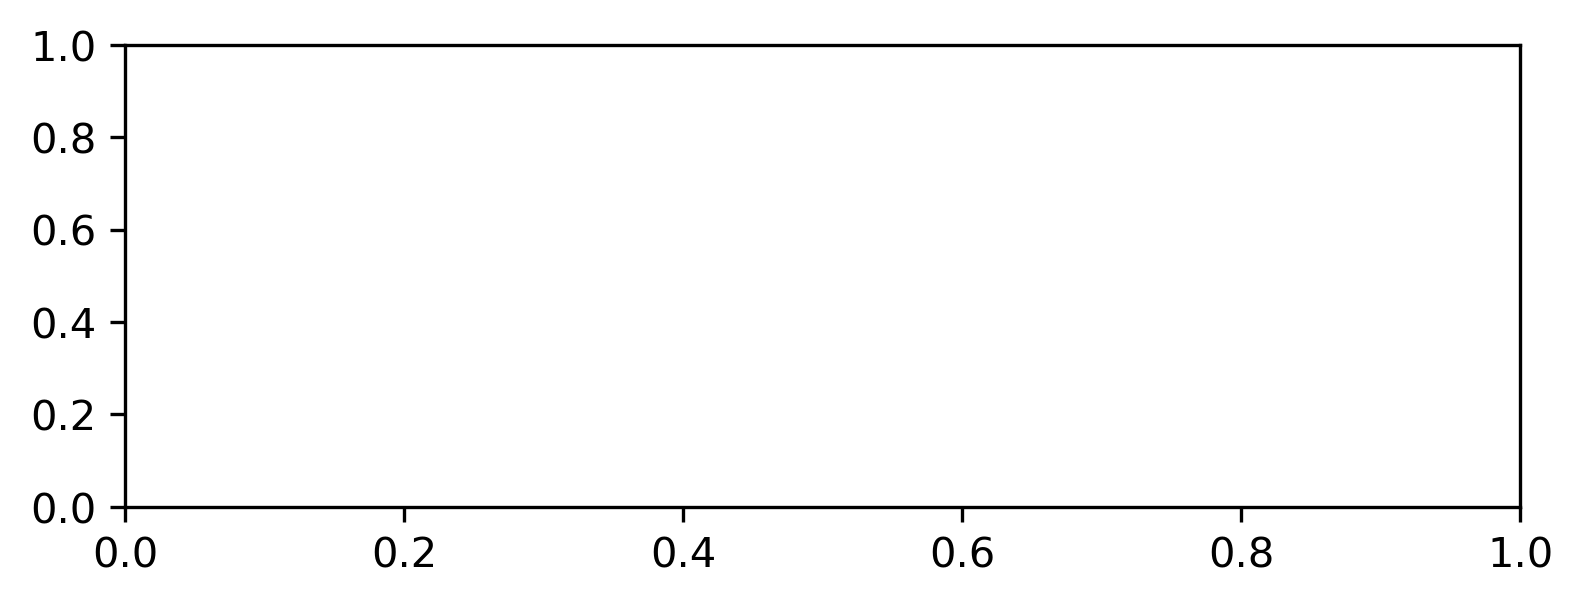

In [70]:
# plot the umap and color it based on the call type

plt.figure(figsize=(6,2), dpi=300)
plt.scatter(umapAll[:, 0], umapAll[:, 1], s=0.1, c=color_labels[cleanInd[0]], cmap='tab20')
plt.title('UMAP colored by call type')

In [47]:
colors = vocSelTable['Tags'].astype('category').cat.codes
print(colors.describe())
colors = colors.to_numpy()
print(colors)
colors = colors[cleanInd[0]]
print(colors)


count    4344.000000
mean        5.426796
std         2.125182
min         0.000000
25%         5.000000
50%         6.000000
75%         7.000000
max         7.000000
dtype: float64
[1 7 6 ... 7 7 2]
[1 1 1 ... 2 2 2]


ValueError: 'c' argument has 104252 elements, which is inconsistent with 'x' and 'y' with size 4340.

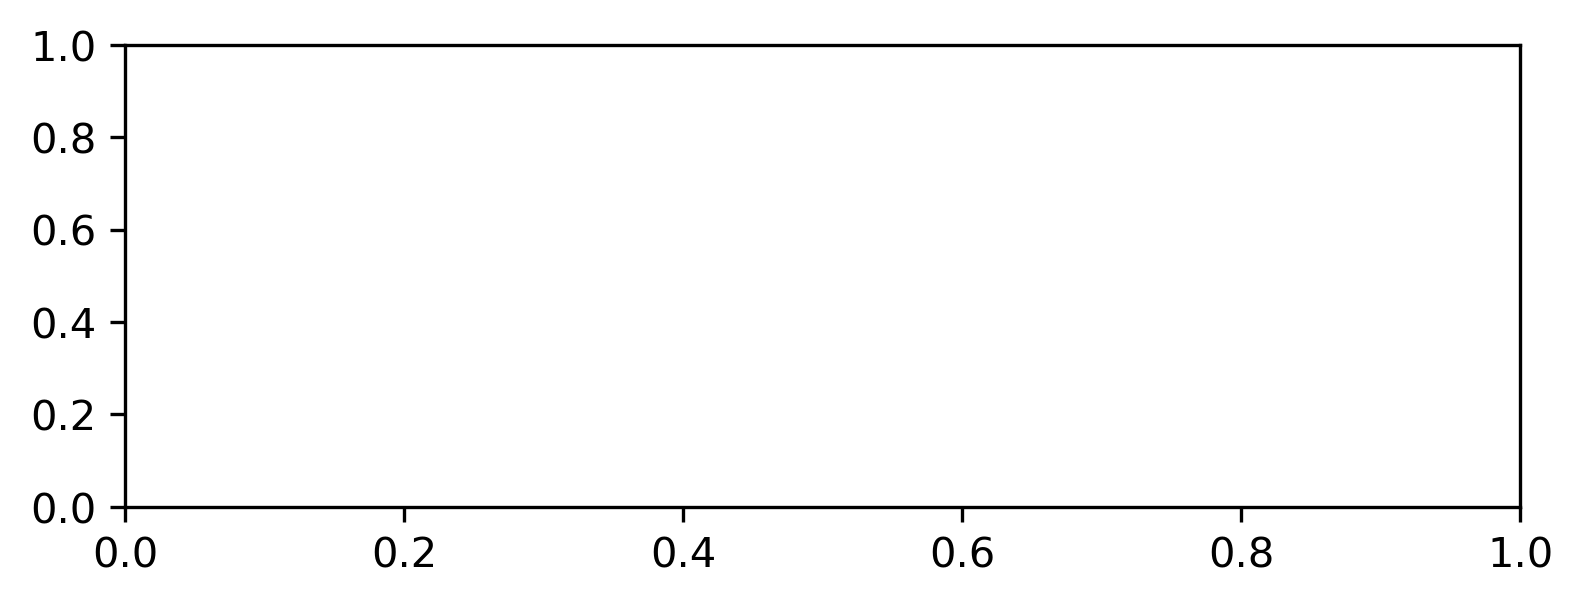

In [46]:
# plot the UMAP and color by the original tags of the call type
colors = vocSelTable['Tags'].astype('category').cat.codes
colors = colors.values
colors = colors[cleanInd[0]]
# colors = colors[cleanInd[0]].values
plt.figure(figsize=(6,2), dpi=300)
plt.scatter(umapAll[:, 0], umapAll[:, 1], s=0.1, c=colors, cmap='tab20b')
plt.title('UMAP colored by soundsep defined call type')

In [34]:
colors

array([1, 1, 1, ..., 2, 2, 2], dtype=int8)